In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
import mlflow

In [2]:
# Chemins vers les images et les données CSV
images_path = "../../data/raw/images/image_train"
X_csv_path = "../../data/processed/X_train_update (komla).csv"
y_csv_path = "../../data/processed/Y_train_CVw08PX (komla).csv"

# Chargement des données
X_df = pd.read_csv(X_csv_path)
y_df = pd.read_csv(y_csv_path)

# Nettoyage de y_df pour enlever toute colonne superflue (comme 'Unnamed: 0')
y_df.drop(columns=["Unnamed: 0"], inplace=True)
X_df.drop(columns=["Unnamed: 0"], inplace=True)

# Assurez-vous que les colonnes 'imageid' et 'productid' sont correctes pour correspondre aux noms de fichiers
X_df["image_name"] = X_df.apply(
    lambda row: f"image_{row['imageid']}_product_{row['productid']}.jpg", axis=1
)
X_df["image_path"] = images_path + "/" + X_df["image_name"]

# Concaténation de X_df avec y_df sur l'index
dataset = pd.concat([X_df, y_df], axis=1)

In [3]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    dataset["image_path"], dataset["prdtypecode"], test_size=0.2, random_state=42
)

In [4]:
# Configuration du générateur de données - Training set
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Configuration du générateur de données - Validation set
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Convertir les étiquettes en chaînes pour répondre aux exigences du générateur
y_train_str = y_train.astype(str)
y_test_str = y_test.astype(str)

# Préparation des générateurs
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train.to_frame(name="image_path").join(
        y_train_str.to_frame(name="prdtypecode")
    ),
    x_col="image_path",
    y_col="prdtypecode",
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=128,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test.to_frame(name="image_path").join(
        y_test_str.to_frame(name="prdtypecode")
    ),
    x_col="image_path",
    y_col="prdtypecode",
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=128,
)

Found 67932 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


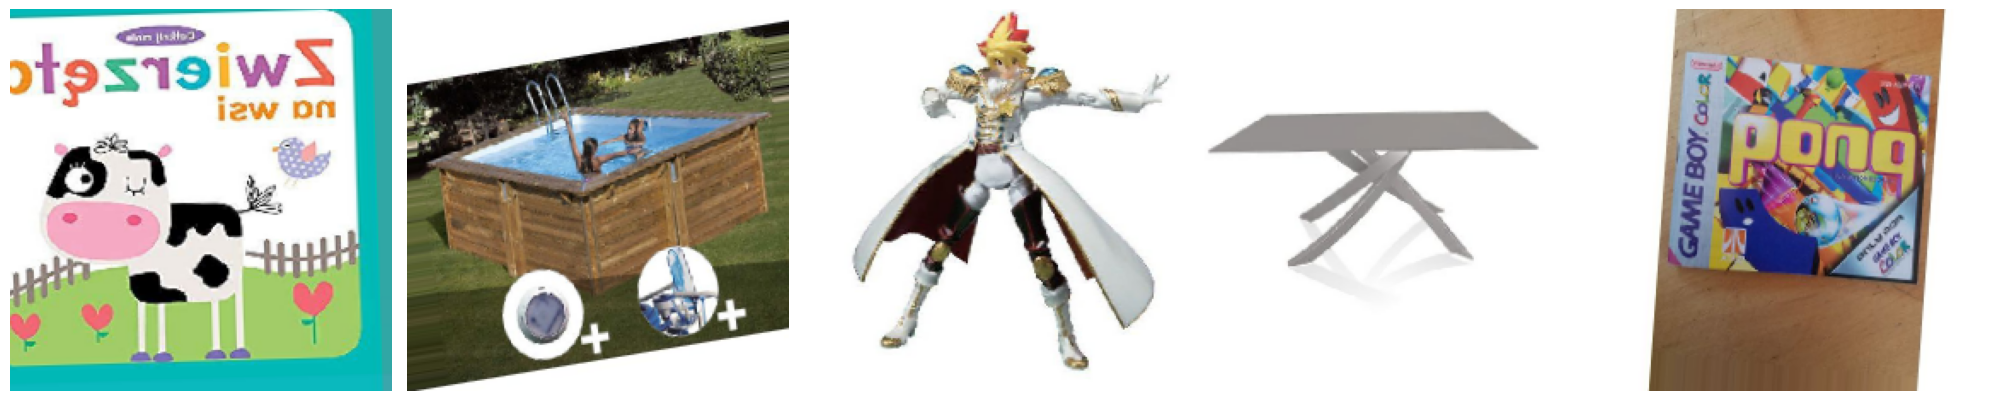

In [5]:
import matplotlib.pyplot as plt


# Création d'une fonction pour tracer des images dans une grille
def plotImages(images_arr, titles=None):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    if titles is not None:
        for title, ax in zip(titles, axes):
            ax.set_title(title)
    plt.tight_layout()
    plt.show()


# Générer des lots d'images augmentées
example_training_images, example_training_labels = next(train_generator)

# Convertir les images en unsigned integers pour l'affichage
example_training_images = example_training_images.astype("uint8")

# Afficher des exemples d'images augmentées
plotImages(example_training_images[:5])

In [6]:
mlflow.set_tracking_uri("../../mlruns")
mlflow.set_experiment("EfficientNetB0")
mlflow.tensorflow.autolog(log_datasets=False)

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1320, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1313, in _read_helper
    result = read_yaml(root, file_name)
  File "/opt/anaconda3/lib/python3.10/site-packages/mlflow/utils/file_utils.py", line 310, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigException: Yaml file '../../mlruns/3826220

In [7]:
# Chargement de EfficientNetB0 comme base du modèle
from tensorflow.keras.applications import EfficientNetB0
from keras.metrics import F1Score

base_model = EfficientNetB0(
    include_top=False, weights="imagenet", input_tensor=Input(shape=(224, 224, 3))
)

# Ajout des couches personnalisées
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)  # taux de dropout à 0.5 pour réduire le surapprentissage
predictions = Dense(len(y_train.unique()), activation="softmax")(
    x
)  # ajustement du nombre de classes selon y_train

model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle pré-entraîné pour ne pas les ré-entraîner
for layer in base_model.layers:
    layer.trainable = False

# Compilation du modèle
f1_score = F1Score(average="weighted")
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1_score]
)

# Afficher le résumé du modèle
model.summary()

2024-05-04 12:42:56.994188: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-04 12:42:56.994251: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-04 12:42:56.994265: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-04 12:42:56.994320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-04 12:42:56.994580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,388,990 (20.56 MB)

 Trainable params: 1,339,419 (5.11 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
with mlflow.start_run() as run:
    print("Run id:", run.info.run_id)
    # Entraînement du modèle
    history = model.fit(
        train_generator, epochs=10, validation_data=test_generator, batch_size=128
    )  # augmentation du nombre d'époques à 10

Run id: 0231b76a1a514e3eab8756cd84cc7669


Epoch 1/10


2024-05-04 12:43:07.404082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/opt/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.4583 - f1_score: 0.4381 - loss: 1.8704

/opt/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


531/531 ━━━━━━━━━━━━━━━━━━━━ 567s 1s/step - accuracy: 0.4584 - f1_score: 0.4382 - loss: 1.8701 - val_accuracy: 0.5688 - val_f1_score: 0.5599 - val_loss: 1.4213
Epoch 2/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.5774 - f1_score: 0.5671 - loss: 1.4127

531/531 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - accuracy: 0.5774 - f1_score: 0.5671 - loss: 1.4127 - val_accuracy: 0.5944 - val_f1_score: 0.5863 - val_loss: 1.3439
Epoch 3/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.6060 - f1_score: 0.5976 - loss: 1.3066

531/531 ━━━━━━━━━━━━━━━━━━━━ 547s 1s/step - accuracy: 0.6060 - f1_score: 0.5976 - loss: 1.3066 - val_accuracy: 0.6073 - val_f1_score: 0.5953 - val_loss: 1.3105
Epoch 4/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.6241 - f1_score: 0.6167 - loss: 1.2243

531/531 ━━━━━━━━━━━━━━━━━━━━ 538s 1s/step - accuracy: 0.6241 - f1_score: 0.6167 - loss: 1.2243 - val_accuracy: 0.6092 - val_f1_score: 0.6012 - val_loss: 1.2870
Epoch 5/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.6407 - f1_score: 0.6345 - loss: 1.1688

531/531 ━━━━━━━━━━━━━━━━━━━━ 531s 989ms/step - accuracy: 0.6407 - f1_score: 0.6345 - loss: 1.1689 - val_accuracy: 0.6161 - val_f1_score: 0.6065 - val_loss: 1.2798
Epoch 6/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 529s 984ms/step - accuracy: 0.6568 - f1_score: 0.6516 - loss: 1.1107 - val_accuracy: 0.6189 - val_f1_score: 0.6099 - val_loss: 1.2875
Epoch 7/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.6688 - f1_score: 0.6640 - loss: 1.0597

531/531 ━━━━━━━━━━━━━━━━━━━━ 531s 988ms/step - accuracy: 0.6688 - f1_score: 0.6639 - loss: 1.0597 - val_accuracy: 0.6242 - val_f1_score: 0.6178 - val_loss: 1.2789
Epoch 8/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.6752 - f1_score: 0.6706 - loss: 1.0341

531/531 ━━━━━━━━━━━━━━━━━━━━ 532s 990ms/step - accuracy: 0.6752 - f1_score: 0.6706 - loss: 1.0342 - val_accuracy: 0.6264 - val_f1_score: 0.6203 - val_loss: 1.2728
Epoch 9/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 531s 989ms/step - accuracy: 0.6891 - f1_score: 0.6851 - loss: 0.9852 - val_accuracy: 0.6194 - val_f1_score: 0.6108 - val_loss: 1.3054
Epoch 10/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.6990 - f1_score: 0.6952 - loss: 0.9535

531/531 ━━━━━━━━━━━━━━━━━━━━ 533s 990ms/step - accuracy: 0.6990 - f1_score: 0.6952 - loss: 0.9535 - val_accuracy: 0.6304 - val_f1_score: 0.6229 - val_loss: 1.3034


2024/05/04 14:12:59 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/05/04 14:12:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/05/04 14:13:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [8]:
import numpy as np
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)


# Calcul du nombre de steps nécessaire pour parcourir les données sans répétition
train_steps = int(np.ceil(len(X_train) / 32))
test_steps = int(np.ceil(len(X_test) / 32))

# Évaluation du modèle sur l'ensemble d'entraînement
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_steps)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

2123/2123 ━━━━━━━━━━━━━━━━━━━━ 7468s 4s/step - accuracy: 0.7744 - loss: 0.7146
Training Loss: 0.7126609086990356
Training Accuracy: 0.7746128439903259


In [9]:
# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

531/531 ━━━━━━━━━━━━━━━━━━━━ 746s 1s/step - accuracy: 0.6200 - loss: 1.4037
Test Loss: 1.4269795417785645
Test Accuracy: 0.6173457503318787
